In [1]:
!pip install datasets
!pip install evaluate
import json
import requests
import pandas as pd
import numpy as np
from datasets import load_dataset
import evaluate
from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


2022-12-19 15:38:58.824466: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-19 15:38:59.910108: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-19 15:38:59.910163: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-19 15:38:59.910192: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
key = '265cc97a8fc6bb1b657b3969b673f19f'
format = 'text' 
url = "https://portulanclarin.net/workbench/lx-proficiency/api/"

In [3]:
raw_test_dataset = load_dataset('csv', data_files='cople_ortho.csv', split='train[90%:]')
labels = pd.read_csv('cople_ortho.csv')['Proficiency'].unique().tolist()
print(labels)

Using custom data configuration default-697819366a407adc
Found cached dataset csv (/home/joao/.cache/huggingface/datasets/csv/default-697819366a407adc/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


['A2', 'B1', 'B2', 'A1', 'C1']


In [4]:
labels.append("C2")

In [5]:
print(raw_test_dataset)

Dataset({
    features: ['Id', 'Proficiency', 'Text'],
    num_rows: 102
})


In [6]:
def class_string_to_int(s):
    if s == 'A1':
        return 0
    if s == 'A2':
        return 1
    if s == 'B1':
        return 2
    if s == 'B2':
        return 3
    if s == 'C1':
        return 4
    if s == 'C2':
        return 5
    else:
        return 404

In [7]:
def tokenize_function(example):
    example['labels'] = [class_string_to_int(proficiency) for proficiency in example['Proficiency']]
    return example

test_datasets = raw_test_dataset.map(tokenize_function, batched=True)

Loading cached processed dataset at /home/joao/.cache/huggingface/datasets/csv/default-697819366a407adc/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-812182a302a3b013.arrow


In [8]:
print(test_datasets)

Dataset({
    features: ['Id', 'Proficiency', 'Text', 'labels'],
    num_rows: 102
})


In [9]:
predictions_df = []
progress_bar = tqdm(range(len(test_datasets)))
errors = []
for entry in test_datasets:
    text = entry['Text']
    request_data = {
        'method': 'analyse',
        'jsonrpc': '2.0',
        'id': 0,
        'params': {
            'text': text,
            'format': format,
            'key': key,
        },
    }
    request = requests.post(url, json=request_data)
    response_data = request.json()
    if "error" in response_data:
        print(f"Error for id {entry['Id']}:", response_data["error"])
        errors.append(entry)
        continue
    else:
        entry['prediction'] = class_string_to_int(response_data["result"].split("\n")[4][-2:])
        predictions_df.append([entry['Id'], entry['prediction'], entry['labels']])
    progress_bar.update(1)

  0%|          | 0/102 [00:00<?, ?it/s]

Error for id zh129CAMTF: {'code': -32000, 'message': 'Server error', 'data': {'type': 'WebServiceException', 'args': ['There was an error while processing your request. Try again later or contact us at helpdesk.'], 'message': 'There was an error while processing your request. Try again later or contact us at helpdesk.'}}
Error for id zh064CAETF: {'code': -32000, 'message': 'Server error', 'data': {'type': 'WebServiceException', 'args': ['There was an error while processing your request. Try again later or contact us at helpdesk.'], 'message': 'There was an error while processing your request. Try again later or contact us at helpdesk.'}}


In [10]:
print(len(predictions_df))
print(len(errors))
print(predictions_df[0])

100
2
['es007CVMTD', 1, 2]


In [11]:
errors

[{'Id': 'zh129CAMTF',
  'Proficiency': 'B1',
  'Text': 'Se eu pertencesse ao grupo Show Me Lisbon, iria fazer muitas coisas para melhorar este grupo. Primeiro, enriqueceria os pacotes de turismo. Acrescentaria Bairro Alto, que é uma zona muito popular entre os jovens portugueses e, de facto, um lugar frequentado pelos locais em vez de turistas. Claro que antes de partir, ensinaria algumas frases de cumprimento em português. Graças ao meu colega turco, experimentámos um restaurante fabuloso turco. Por isso, recomendaria ao meu cliente este restaurante. Embora não seja um restaurante português, é sempre bom experimentar novidades. A cultura de café português também é muito famosa. Eu e o meu cliente iríamos a um cafeteria/café portuguesa /português, tomaríamos um café, olharíamos as pessoas que estão em pé em frente do balcão, rindo, que conversando, falando. É muito giro. Além de enriquecer os pacotes, também faria mais propagandas. Deixaria mais panfletos no hostel, no hotel, no aeropo

In [16]:
text = "anúncio de emprego no dia 22 de Maio. Exel. Sr.,O anúncio de emprego no dia 22 de Maio no Jornal Comércio parece-me muito interessante porque eu sou professora de chinês, que mora em Lisboa e tenho muitas experiências de ensinar chinês para alunos portugueses e de ser tradutora. Eu posso falar e escrever inglês muito bem e gosto de aproveitar as novas tecnologias, computadores e jogos. Além disso, posso trabalhar ao fim de semana especialmente. Acho que sou óptima para esta posição e vou ser uma boa emprega na funcionária da sua empresa. Mas faça o favor de me dizer, se possível, o horário de trabalho, o vencimento e a experiência necessária porque queria saber mais informações sobre a sua empresa e não queria perder esta oportunidade tão especial para mim. Muito obrigada e bom dia!Até logo, FF."
request_data = {
    'method': 'analyse',
    'jsonrpc': '2.0',
    'id': 0,
    'params': {
        'text': text,
        'format': format,
        'key': key,
    },
}
request = requests.post(url, json=request_data)
response_data = request.json()
if "error" in response_data:
    print(f"Error for id: ", response_data["error"])
    errors.append(entry)
else:
    pred = class_string_to_int(response_data["result"].split("\n")[4][-2:])
    predictions_df.append(["zh064CAETF", pred, 1])

In [20]:
len(predictions_df)/102

1.0

In [21]:
df = pd.DataFrame(predictions_df, columns=['Id', 'Predictions', 'labels'])

In [22]:
# Getting acess key status:
request_data = {
    'method': 'key_status',
    'jsonrpc': '2.0',
    'id': 0,
    'params': {
        'key': key,
    },
}
request = requests.post(url, json=request_data)
response_data = request.json()
if "error" in response_data:
    print("Error:", response_data["error"])
else:
    print("Key status:")
    print(json.dumps(response_data["result"], indent=4))

Key status:
{
    "requests_remaining": 99588,
    "chars_remaining": 99605089,
    "expiry": "2023-01-11T19:01+00:00"
}


In [23]:
df.head()

,Id,Predictions,labels
0,es007CVMTD,1,2
1,ru022CVMTF_2,2,2
2,fr034CVMTF,4,2
3,de037CVSTF,4,4
4,de013CVITI,0,0


In [24]:
def class_int_to_str(number):
    if number == 0:
        return 'A1'
    if number == 1:
        return 'A2'
    if number == 2:
        return 'B1'
    if number == 3:
        return 'B2'
    if number == 4:
        return 'C1'
    if number == 5:
        return 'C2'
    else:
        return 'Error'

/tmp/ipykernel_3857/1990019565.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', 'A1', 'A2', 'B1', 'B2', 'C1', 'C2'])
/tmp/ipykernel_3857/1990019565.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', 'A1', 'A2', 'B1', 'B2', 'C1', 'C2'])


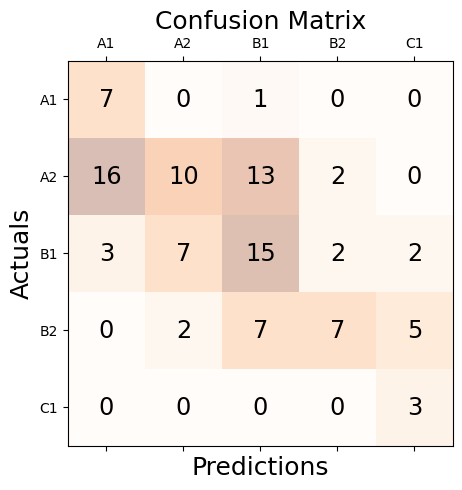

In [28]:
conf_matrix = confusion_matrix(y_true=df['labels'], y_pred=df['Predictions'])

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

ax.set_xticklabels(['', 'A1', 'A2', 'B1', 'B2', 'C1', 'C2'])
ax.set_yticklabels(['', 'A1', 'A2', 'B1', 'B2', 'C1', 'C2'])
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [29]:
print('Accuracy: %.3f' % accuracy_score(df['labels'], df['Predictions']))
print('Precision: %.3f' % precision_score(df['labels'], df['Predictions'], average='weighted'))
print('Recall: %.3f' % recall_score(df['labels'], df['Predictions'], average='weighted'))
print('F1 Score: %.3f' % f1_score(df['labels'], df['Predictions'], average='weighted'))

Accuracy: 0.412
Precision: 0.491
Recall: 0.412
F1 Score: 0.401


In [30]:
df.to_csv("portulan_clarin_predictions_cople_last_10%.csv")